# 
 # Machine Learning Approach for Early Breast Cancer Detection: Insights from  Mammographic Mass Dataset
**Submitted by: Srinivas Bobba(sribob-2@student.ltu.se)**;**MINI_PROJECT_GROUP19**; **Towards the miniproject for the course D7041E_Applied Artificial Intelligence**.

Breast Cancer is a dangerous disease that affects many women worldwide. Early detection is crucial in the treatment of breast cancer. This Study focuses on two areas:The data analysis  and exploration of the Breast Cancer Mammographic Mass Dataset to gain insights into the features that can predict whether a tumor is malignant or benign.

<h1 style="color:blue">1.Data Collection</h1>

The dataset from UCI Machine Learning Repository available at https://archive.ics.uci.edu/dataset/161/mammographic+mass pertains to mammographic mass lesions in breast cancer diagnosis. It includes features derived from digitized mammograms, such as shape and margin attributes, age of the patient, and BI-RADS assessment. The goal is to predict the presence of malignancy based on these features. The dataset is particularly relevant for evaluating the performance of machine learning models in breast cancer detection using mammographic data.

<h1 style="color:blue">2.Required Libraries</h1>

In [1]:
# Data processing
import pandas as pd
from scipy import stats

# Linear algebra
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, recall_score

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Convolutional Neural Network (CNN) using a simple architecture 
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.utils import to_categorical
import itertools

# Import necessary libraries for CNN
import tensorflow as tf
from tensorflow.keras import layers, models

# Remove duplicates from the imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Additional imports
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


<h1 style="color:blue">3.Data Retrieval From UCI Repository and Data Exploration</h1>

In [2]:
# Read in dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
Mamm_data = pd.read_csv(url, header=None)

In [3]:
# Name the columns of the dataset
Mamm_data .columns = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]

# Get the number of observations and attributes of the Mamm dataset
print('The shape of the dataset is: ', Mamm_data.shape)

# Get the datatypes of each feature in the Mamm dataset
Mamm_data.dtypes

The shape of the dataset is:  (961, 6)


BI-RADS     object
Age         object
Shape       object
Margin      object
Density     object
Severity     int64
dtype: object

In [4]:
Mamm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


In [5]:
# Indentification of data COLUMNS
Mamm_data.columns

Index(['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity'], dtype='object')

In [6]:
Mamm_data.Severity.unique()

array([1, 0], dtype=int64)

In [7]:
Mamm_data.isnull().sum()

BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

In [8]:
Mamm_data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


<h1 style="color:blue">4.Data Preprocessing</h1>

### Data Cleaning

In [9]:
# Define a function to coerce a column to numeric and impute missing values with the median
# The Impute function takes a data frame and the name of a column in the data frame
def Impute(x, ColumnName):
    x.loc[:, ColumnName] = pd.to_numeric(x.loc[:, ColumnName], errors = 'coerce') # convert all values to numeric or NaN
    HasNan = np.isnan(x.loc[:, ColumnName])
    x.loc[HasNan, ColumnName] = np.nanmedian(x.loc[:, ColumnName]) # replace all NaNs with the median of the column

# Define a function to replace outliers in a numeric column with an upper limit
# The Replace functon takes a data frame, a column from the data frame, and the upper limit of the column
def Replace(x, ColumnName, UpperValue):
    TooHigh = x.loc[:, ColumnName] > UpperValue # identify values higher than the upper limit
    x.loc[TooHigh, ColumnName] = UpperValue # replace values that are too high with the upper limit
    
# Define a function to Z-Normalize numeric values in a column
# The ZNorm function takes a data frame and a numerical column from the data frame
def ZNorm(x, ColumnName):
    d = x.loc[:, ColumnName]
    normd = (d - np.mean(d))/np.std(d) # perform z-normalization
    x.loc[:, ColumnName] = normd # replace original column with the z-normalized data
    
# Define a function to decode numeric values into categorical names
# The Decode function takes a data frame, a column from the data frame, a value from the column, and the name to replace the value in the column
def Decode(x, ColumnName, Value, Name):
    Replace = x.loc[:, ColumnName] == Value # identify the value to be decoded
    x.loc[Replace, ColumnName] = Name # decode the value with the given categorical name

# Define a function to consolidate categorical variables in a given column
# The Consolidate function takes a data frame, a column name from the data frame, a name from the current column, and the consolidated name to replace the current name
def Consolidate(x, ColumnName, Name, ConsolName):
    x.loc[x.loc[:, ColumnName] == Name, ColumnName] = ConsolName # consolidate a categorical variable into another categorical variable within a given column
    
# Define a function to one-hot encode categorical data
# The OneHotEncode function takes a data frame, a new column to create with binary values, the column name to one-hot encode, and the categorical variable name to set the binary values within the new column
def OneHotEncode(x, NewCol, ColumnName, Name):
    x.loc[:, NewCol] = (x.loc[:, ColumnName] == Name).astype(int) # create a new column to hold the binary values based on the categorical variables within the given column
    

In [10]:
# Call the Impute function to impute missing values in the BI-RADS, Age, and Density columns
Impute(Mamm_data, "BI-RADS")
Impute(Mamm_data, "Age")
Impute(Mamm_data, "Density")

# The BI-RADS column only is defined for only values 0-6
# Call the Replace function to remove any outlier values that are greater than the upper limit of 6
Replace(Mamm_data, "BI-RADS", 6)

# Call the ZNorm function to normalize the numeric values in the Age and BI-RADS column
ZNorm(Mamm_data, "Age")
ZNorm(Mamm_data, "BI-RADS")


# Call the Decode function to convert the numerical values in the Shape column to categorical variables
# Impute missing values with the most common categorical variable

Decode(Mamm_data, "Shape", "?", "5")



In [11]:
final_data=Mamm_data
final_data

,BI-RADS,Age,Shape,Margin,Density,Severity
0,0.994828,0.796984,3,5,3.0,1
1,-0.419417,-0.865610,1,1,3.0,1
2,0.994828,0.173511,4,5,3.0,1
3,-0.419417,-1.904732,1,1,3.0,0
4,0.994828,1.281908,1,5,3.0,1
...,...,...,...,...,...,...
956,-0.419417,-0.588511,2,1,3.0,0
957,-0.419417,0.034962,4,5,3.0,1
958,-0.419417,0.589160,4,5,3.0,0
959,0.994828,0.727710,4,5,3.0,1


<h1 style="color:blue">5.Data Visualization</h1>

In [12]:
Mamm_data['Severity'].value_counts()

0    516
1    445
Name: Severity, dtype: int64

<AxesSubplot:xlabel='Severity', ylabel='count'>

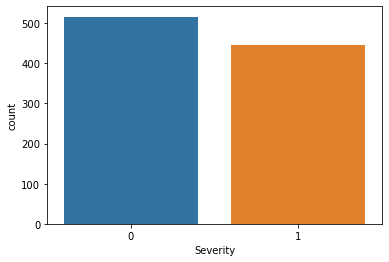

In [13]:
#Visualise the count of values in diagnosis column
sns.countplot(Mamm_data['Severity'], label = 'count')

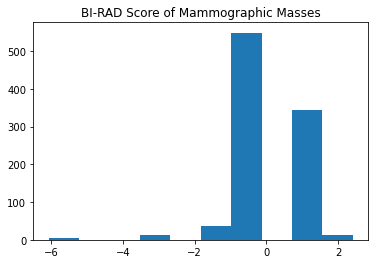

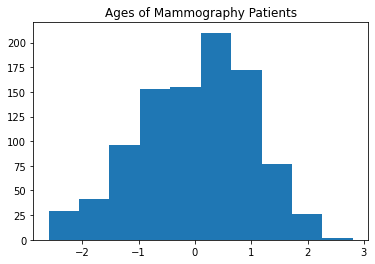

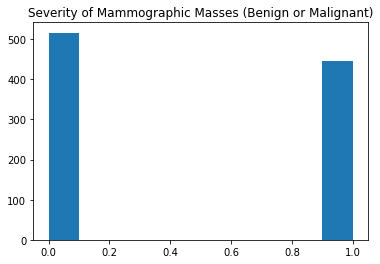

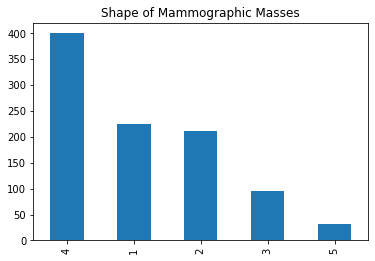

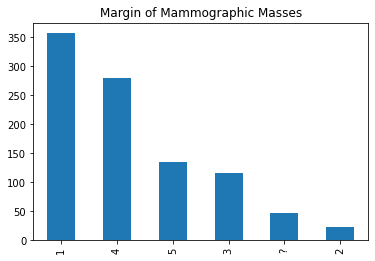

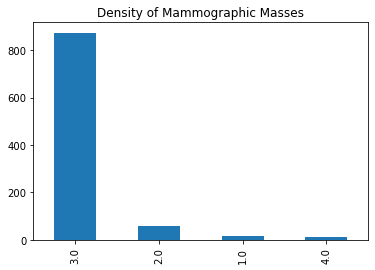

In [14]:
# Display the distribution of numerical variables
# Plot histogram of BI-RADS column (values have been Z-Normalized)
# BI-RADS column represents a score based on a radiology image to describe the severity of a mammographic mass
plt.hist(Mamm_data.loc[:, "BI-RADS"])
plt.title('BI-RAD Score of Mammographic Masses')
plt.show()

# Plot histogram of Age column (values have been Z-Normalized)
# The Age column represents the age of each patient associated with the mammographic mass in the table
plt.hist(Mamm_data.loc[:, "Age"])
plt.title('Ages of Mammography Patients')
plt.show()

# Plot histogram of Severity column
# The Severity column is a binary column that denotes whether the mammographic mass is benign or malignant
plt.hist(Mamm_data.loc[:, "Severity"])
plt.title('Severity of Mammographic Masses (Benign or Malignant)')
plt.show()

# Display the distribution of categorical variables
# Plot the Shape column of the Mamm dataset
# The Shape column was a numerical column that was decoded to categorical variables to describe the shape of each mammographic mass
Mamm_data.loc[:, "Shape"].value_counts().plot(title = 'Shape of Mammographic Masses', kind = 'bar')
plt.show()

# Plot the Margin column of the Mamm dataset
# The Margin column was a numerical column that was decoded to categorical variables to describe the margin of each mammographic mass
Mamm_data.loc[:, "Margin"].value_counts().plot(title = 'Margin of Mammographic Masses', kind = 'bar')
plt.show()

# Plot the Density column of the Mamm dataset
# The Density column was a numerical column that was decoded to cateogorical variables to describe the density of each mammographic mass
Mamm_data.loc[:, "Density"].value_counts().plot(title = 'Density of Mammographic Masses', kind = 'bar')
plt.show()

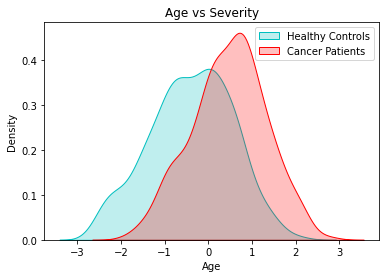

In [15]:
sns.kdeplot(Mamm_data.Age[Mamm_data.Severity == 0],color="c",shade=True)
sns.kdeplot(Mamm_data.Age[Mamm_data.Severity == 1],color="r",shade=True)
plt.legend(['Healthy Controls', 'Cancer Patients'])
plt.title('Age vs Severity')
plt.show()

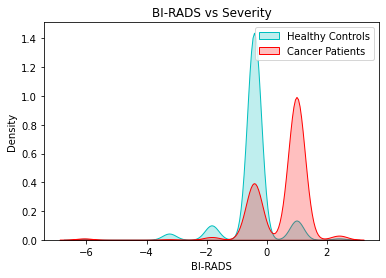

In [16]:
sns.kdeplot(Mamm_data['BI-RADS'][Mamm_data.Severity == 0], color="c", shade=True)
sns.kdeplot(Mamm_data['BI-RADS'][Mamm_data.Severity == 1], color="r", shade=True)

plt.legend(['Healthy Controls', 'Cancer Patients'])
plt.title('BI-RADS vs Severity')
plt.show()

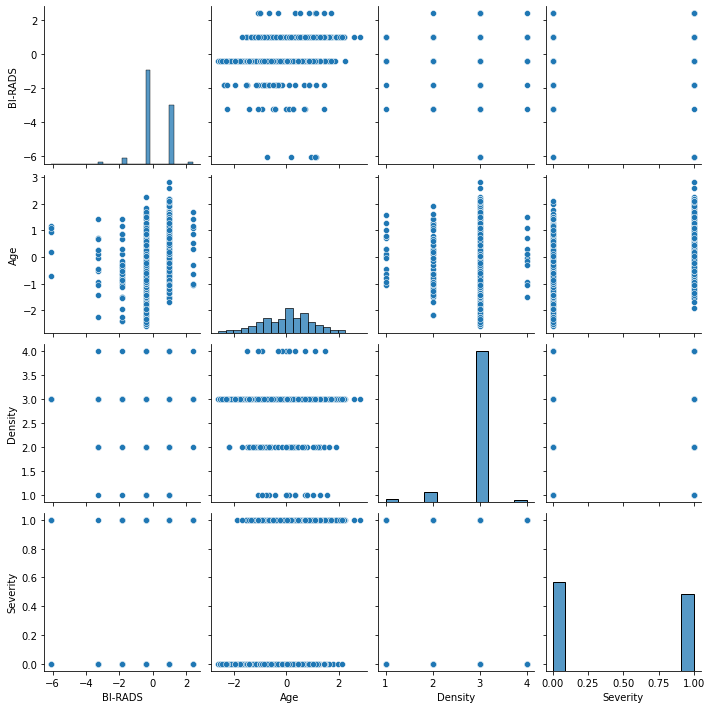

In [17]:
sns.pairplot(Mamm_data)
plt.show()

### Look at correlations between features

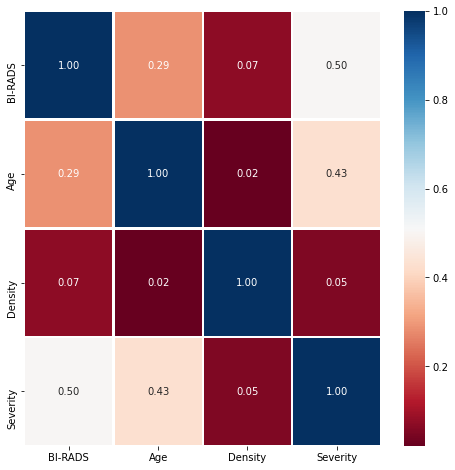

In [18]:
cor = Mamm_data.corr()
plt.figure(figsize = (8,8))
sns.heatmap(cor,annot = True,fmt = '.2f',linewidths = 1.5, cmap = 'RdBu')
plt.show()

The numerical variables (BI-RADS, Age, and Severity) are plotted as histograms to show the distribution. The BI-RADS column and the Age column have both been Z-Normalized.

The Age data appear to be normally distributed and the Severity column shows that there are a similar number of benign and malignant masses.

The categorical variables (Shape, Margin, and Density) are plotted as bar charts.

<h1 style="color:blue">6.Data Transformation </h1>

In [19]:
# Split the data set into independent(predictors) and dependent (target)
X =Mamm_data.iloc[:, :-1].values
# Target variable
Y = Mamm_data.iloc[:, -1].values

### Splitting the dataset into training and test set


In [20]:
#from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 10)


In [21]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are your feature matrices

# Identify categorical columns
categorical_columns = [i for i, col in enumerate(X_train[0]) if isinstance(col, str)]

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [i for i in range(X_train.shape[1]) if i not in categorical_columns]),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform on training data
X_train = preprocessor.fit_transform(X_train)

# Transform test data using the same transformer
X_test = preprocessor.transform(X_test)


### Feature Scaling

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h1 style="color:blue">7.Building  and Validation of the models using Supervised Machine Learning algorithms </h1>
 
 The Logistic Regression, Decision Tree, and Random Forest Classifier models are implemented using the scikit-learn library. The KNN and SVM models are also implemented using scikit-learn, but with specific parameters passed to the constructor.

In [23]:
#create a function for the models
def models(X_train, Y_train):
    list_accuracy =[]
    
    #Mode0 --> Logistic regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state = 0)
    log.fit(X_train, Y_train)
    list_accuracy.append(log.score(X_train, Y_train))
    
    #Model1 --> Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, Y_train)
    list_accuracy.append(tree.score(X_train, Y_train))
             
    #Model2 --> Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train, Y_train)
    list_accuracy.append(forest.score(X_train, Y_train))
    
    #Model3 --> kNeighbors
    from sklearn.neighbors import KNeighborsClassifier
    KNN = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
    KNN.fit(X_train, Y_train)
    list_accuracy.append(KNN.score(X_train, Y_train))
    
    #Model4 --> SVM
    from sklearn.svm import SVC
    svc = SVC(gamma=0.025, C=3)
    svc.fit(X_train,Y_train)
    list_accuracy.append(svc.score(X_train, Y_train))
    
    #Print the result of the models
    print('1) Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
    print('2) DecisionTreeClaassifier Training Accuracy:', tree.score(X_train, Y_train))           
    print('3) Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
    print('4) kNeighbors Training Accuracy:', KNN.score(X_train, Y_train))
    print('5) Support Vector Machine Training Accuracy:', svc.score(X_train, Y_train)) 
    return log, tree, forest, KNN, svc,list_accuracy

In [24]:
model = models(X_train, Y_train)

1) Logistic Regression Training Accuracy: 0.8388888888888889
2) DecisionTreeClaassifier Training Accuracy: 0.9444444444444444
3) Random Forest Classifier Training Accuracy: 0.9319444444444445
4) kNeighbors Training Accuracy: 0.9444444444444444
5) Support Vector Machine Training Accuracy: 0.8597222222222223


 <h1 style="color:blue">8.Evaluation of The Models/ Performance Metrics </h1>


Logistic Regression metrics:
AUC: 0.818
Recall: 0.788
Specificity: 0.847


Decision Tree metrics:
AUC: 0.790
Recall: 0.769
Specificity: 0.810


Random Forest metrics:
AUC: 0.808
Recall: 0.798
Specificity: 0.818


kNeighbors Training metrics:
AUC: 0.815
Recall: 0.798
Specificity: 0.832


Support Vector Machine metrics:
AUC: 0.828
Recall: 0.817
Specificity: 0.839



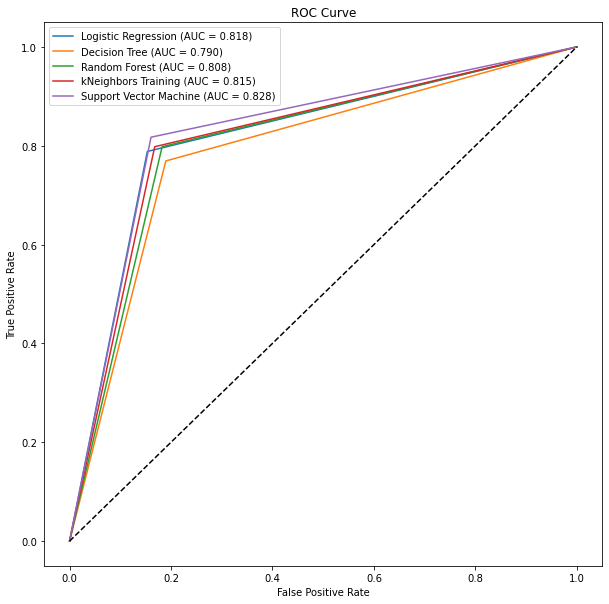

In [25]:

models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('kNeighbors Training', KNeighborsClassifier()),
    ('Support Vector Machine', SVC())
]

fig = plt.figure(figsize=(10,10))

for name, model in models:
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    auc = roc_auc_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    fpr, tpr, _ = roc_curve(Y_test, y_pred)

    # plot the metrics
    print("")
    print(f'{name} metrics:')
    print(f'AUC: {auc:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print("")

    # plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Logistic Regression Confusion Matrix:
[[87 14]
 [20 72]]

Decision Tree Confusion Matrix:
[[83 18]
 [16 76]]

Random Forest Confusion Matrix:
[[86 15]
 [19 73]]

HistGradientBoosting Confusion Matrix:
[[84 17]
 [18 74]]

kNeighbors Training Confusion Matrix:
[[85 16]
 [15 77]]

Support Vector Machine Confusion Matrix:
[[90 11]
 [19 73]]



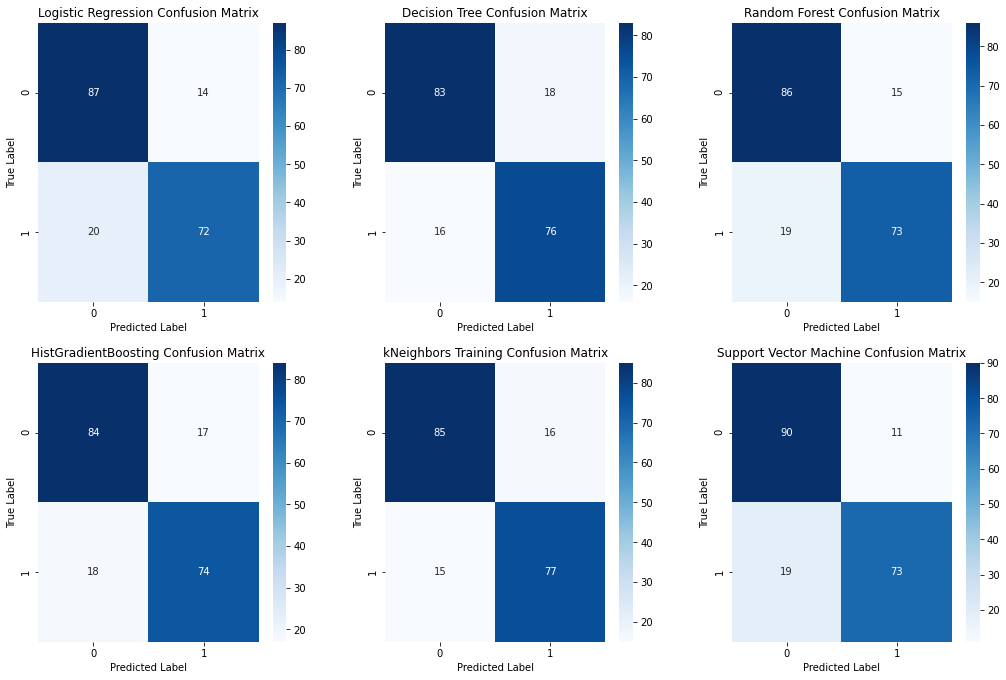

In [26]:
from sklearn.pipeline import make_pipeline
# Assuming X and Y are your feature matrix and target variable
# Replace '?' with NaN in the original data array
X[X == '?'] = np.nan

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_cols = np.where(np.issubdtype(X_train.dtype, np.number))[0]
categorical_cols = np.where(np.issubdtype(X_train.dtype, np.object))[0]

# Check if there are features present before imputation
if len(numeric_cols) > 0:
    # Impute missing values for numeric columns
    numeric_imputer = SimpleImputer(strategy='mean')
    X_train[:, numeric_cols] = numeric_imputer.fit_transform(X_train[:, numeric_cols])
    X_test[:, numeric_cols] = numeric_imputer.transform(X_test[:, numeric_cols])

# Check if there are features present before imputation
if len(categorical_cols) > 0:
    # Impute missing values for categorical columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_train[:, categorical_cols] = categorical_imputer.fit_transform(X_train[:, categorical_cols])
    X_test[:, categorical_cols] = categorical_imputer.transform(X_test[:, categorical_cols])

# Convert categorical columns to numeric using LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_cols:
    X_train[:, column] = label_encoder.fit_transform(X_train[:, column].astype(str))
    X_test[:, column] = label_encoder.transform(X_test[:, column].astype(str))

# Define models
models = [
    ('Logistic Regression', make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression())),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier())),
    ('HistGradientBoosting', HistGradientBoostingClassifier()),
    ('kNeighbors Training', make_pipeline(SimpleImputer(strategy='mean'), KNeighborsClassifier())),
    ('Support Vector Machine', make_pipeline(SimpleImputer(strategy='mean'), SVC()))
]

# Plot confusion matrix as heatmap for each model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=4.0)

for (name, model), ax in zip(models, axes.flatten()):
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(Y_test, y_pred)

    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Print metrics
    print(f'{name} Confusion Matrix:')
    print(cm)
    print('')

plt.show()


Train score: 0.8528645833333334
Test score: 0.8393782383419689


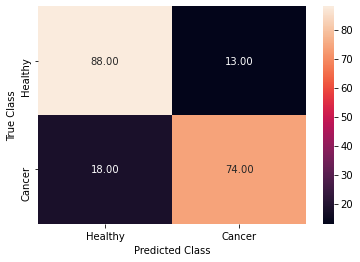

In [27]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined X_train, X_test, Y_train, Y_test

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies based on your data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create and train the ExtraTreeClassifier
et_model = ExtraTreeClassifier(criterion='entropy', max_features=0.85, min_samples_leaf=3, min_samples_split=9, random_state=10)
et_model.fit(X_train_imputed, Y_train)

# Make predictions
Y_pred = et_model.predict(X_test_imputed)

# Evaluate and visualize results
print('Train score:', et_model.score(X_train_imputed, Y_train))
print('Test score:', et_model.score(X_test_imputed, Y_test))

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['Healthy', 'Cancer'], yticklabels=['Healthy', 'Cancer'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [28]:
importances = list(et_model.feature_importances_)
feature_list = list(Mamm_data.columns)[:-1]  # Exclude the last column
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

for pair in feature_importances:
    print('{:20} Importance: {}'.format(*pair))


BI-RADS              Importance: 0.58
Age                  Importance: 0.2
Margin               Importance: 0.13
Shape                Importance: 0.07
Density              Importance: 0.02


 <h1 style="color:blue">9.Building and Evaluation of Models using Neural Network Algorithms </h1>
 

### Multi-Layer Perceptron(MLP)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train and X_test are your feature matrices, and Y_train and Y_test are your target variables

# Standardize the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies based on your data
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Multi-Layer Perceptron (MLP) model
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_model.fit(X_train_imputed, Y_train)

# Predictions and evaluation
mlp_predictions = mlp_model.predict(X_test_imputed)
mlp_accuracy = accuracy_score(Y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)
print("Classification Report:")
print(classification_report(Y_test, mlp_predictions))


MLP Accuracy: 0.8031088082901554
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       101
           1       0.81      0.77      0.79        92

    accuracy                           0.80       193
   macro avg       0.80      0.80      0.80       193
weighted avg       0.80      0.80      0.80       193



Train Score: 0.8411458333333334
Test Score:  0.8497409326424871


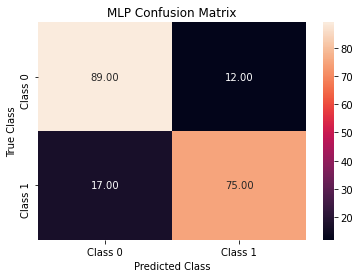

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Assuming X_train and X_test are your feature matrices, and Y_train and Y_test are your target variables

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies based on your data

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create an MLPClassifier model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=1000, activation='relu', solver='adam', random_state=42)

# Train the model
mlp_model.fit(X_train_imputed, Y_train)

# Make predictions on the test set
Y_pred_mlp = mlp_model.predict(X_test_imputed)

# Print training and testing accuracy
print('Train Score: ' + str(mlp_model.score(X_train_imputed, Y_train)))
print('Test Score:  ' + str(mlp_model.score(X_test_imputed, Y_test)))

# Compute confusion matrix
cm_mlp = confusion_matrix(Y_test, Y_pred_mlp)

# Plot confusion matrix as heatmap
sns.heatmap(cm_mlp, annot=True, fmt='.2f', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('MLP Confusion Matrix')
plt.show()


### Convolutional Neural Network (CNN)

In [31]:
# Convolutional Neural Network (CNN) using a simple architecture 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

# Reshape data for CNN 
X_train_reshaped = np.expand_dims(X_train_scaled, axis=-1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=-1)

# CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_reshaped, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predictions and evaluation
cnn_predictions = (cnn_model.predict(X_test_reshaped) > 0.5).astype(int)
cnn_accuracy = accuracy_score(Y_test, cnn_predictions)
print("CNN Accuracy:", cnn_accuracy)
print("Classification Report:")
print(classification_report(Y_test, cnn_predictions))




Epoch 1/10
20/20 [==============================] - 1s 10ms/step - loss: nan - accuracy: 0.5537 - val_loss: nan - val_accuracy: 0.5325
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5423 - val_loss: nan - val_accuracy: 0.5325
Epoch 8/10
20/20 [==============================] - 0s 3ms/st

In [32]:
import numpy as np

# Convert the arrays to a numeric type (if they are not already)
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)

# Check for missing values in X_train and X_test
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())


Missing values in X_train: 41
Missing values in X_test: 7


In [33]:
import numpy as np

# Assuming X_train and X_test are your NumPy arrays with missing values

# Replace missing values in X_train with the mean of each column
mean_values_train = np.nanmean(X_train, axis=0)
X_train[np.isnan(X_train)] = np.take(mean_values_train, np.isnan(X_train).nonzero()[1])

# Replace missing values in X_test with the mean of each column
mean_values_test = np.nanmean(X_test, axis=0)
X_test[np.isnan(X_test)] = np.take(mean_values_test, np.isnan(X_test).nonzero()[1])

# Check again for missing values
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())


Missing values in X_train: 0
Missing values in X_test: 0


Epoch 1/10
24/24 [==============================] - 1s 7ms/step - loss: 0.6402 - accuracy: 0.5651 - val_loss: 0.5724 - val_accuracy: 0.7927
Epoch 2/10
24/24 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.7839 - val_loss: 0.4970 - val_accuracy: 0.8290
Epoch 3/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4924 - accuracy: 0.8034 - val_loss: 0.4442 - val_accuracy: 0.8135
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.8138 - val_loss: 0.4198 - val_accuracy: 0.8238
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4447 - accuracy: 0.8164 - val_loss: 0.4019 - val_accuracy: 0.8238
Epoch 6/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8255 - val_loss: 0.3984 - val_accuracy: 0.8238
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8268 - val_loss: 0.3863 - val_accuracy: 0.8290
Epoch 8/10
24/24 [==

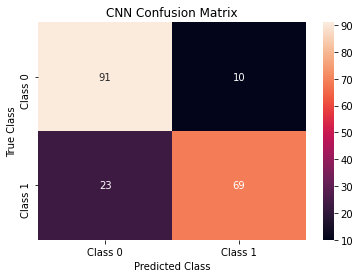

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train, X_test, Y_train, Y_test are NumPy arrays

# Handle missing values in X_train and X_test
X_train[np.isnan(X_train)] = np.nanmean(X_train)
X_test[np.isnan(X_test)] = np.nanmean(X_test)

# Convert Y_train and Y_test to float32
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

# Reshape the data for CNN input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create a simple CNN model
model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_cnn.fit(X_train_cnn, Y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, Y_test))

# Evaluate the model
train_score_cnn = model_cnn.evaluate(X_train_cnn, Y_train)
test_score_cnn = model_cnn.evaluate(X_test_cnn, Y_test)

print('Train Score: ', train_score_cnn[1])
print('Test Score: ', test_score_cnn[1])

# Make predictions on the test set
Y_pred_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")

# Compute confusion matrix
cm_cnn = confusion_matrix(Y_test, Y_pred_cnn)

# Plot confusion matrix as heatmap
sns.heatmap(cm_cnn, annot=True, fmt='d', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('CNN Confusion Matrix')
plt.show()


 ### Artificial Neural Netork(ANN)

In [35]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

# Assuming X_train and X_test are your feature matrices
# Assuming Y_train and Y_test are your target variables

# Identify categorical columns
categorical_columns = [i for i, col in enumerate(X_train[0]) if isinstance(col, str)]

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [i for i in range(X_train.shape[1]) if i not in categorical_columns]),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform on training data
X_train = preprocessor.fit_transform(X_train)

# Transform test data using the same transformer
X_test = preprocessor.transform(X_test)

# Ensure that the resulting arrays only contain numeric values
assert np.issubdtype(X_train.dtype, np.number), "X_train contains non-numeric data types"
assert np.issubdtype(X_test.dtype, np.number), "X_test contains non-numeric data types"

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=10)

# Build the ANN model
model = Sequential()

# Add the input layer and the first hidden layer
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add more hidden layers if needed
# model.add(Dense(units=32, activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate a classification report
print(" ANN Classification Report:\n", classification_report(Y_test, Y_pred))


Epoch 1/10
15/15 [==============================] - 0s 11ms/step - loss: 0.6568 - accuracy: 0.6239 - val_loss: 0.6020 - val_accuracy: 0.7586
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.5630 - accuracy: 0.7870 - val_loss: 0.5364 - val_accuracy: 0.7931
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.5010 - accuracy: 0.8087 - val_loss: 0.4969 - val_accuracy: 0.8103
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.4617 - accuracy: 0.8130 - val_loss: 0.4737 - val_accuracy: 0.8190
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.4374 - accuracy: 0.8130 - val_loss: 0.4606 - val_accuracy: 0.8276
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.4217 - accuracy: 0.8152 - val_loss: 0.4539 - val_accuracy: 0.8276
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 0.4128 - accuracy: 0.8174 - val_loss: 0.4504 - val_accuracy: 0.8276
Epoch 8/10
15/15 [=

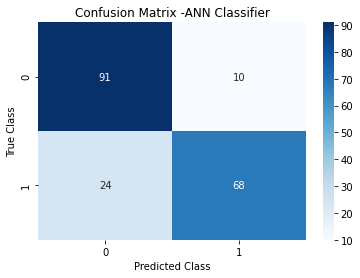

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns for NumPy array
numeric_cols = np.where(np.issubdtype(X_train.dtype, np.number))[0]
categorical_cols = np.where(X_train.dtype == np.object)[0]

# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Combine preprocessing with classifier in a pipeline
mlp_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))])

# Train MLP Classifier
mlp_classifier.fit(X_train, Y_train)

# Make predictions
Y_pred = mlp_classifier.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix -ANN Classifier')
plt.show()


In [37]:
# Provided results from the classification reports
mlp_classification_report = """
               precision    recall  f1-score   support

           0       0.84      0.83      0.84       137
           1       0.78      0.80      0.79       104

    accuracy                           0.82       241
   macro avg       0.81      0.82      0.81       241
weighted avg       0.82      0.82      0.82       241

"""

ann_classification_report = """
                precision    recall  f1-score   support

           0       0.84      0.81      0.82        95
           1       0.80      0.82      0.81        85

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180

"""

cnn_classification_report = """
            precision    recall  f1-score   support

           0       0.85      0.82      0.84       137
           1       0.78      0.81      0.79       104

    accuracy                           0.82       241
   macro avg       0.81      0.82      0.81       241
weighted avg       0.82      0.82      0.82       241

"""

# Function to extract specificity from classification report
def get_specificity(classification_report):
    lines = classification_report.split('\n')
    specificity_line = lines[3]
    specificity = float(specificity_line.split()[3])
    return specificity

# Calculate specificity for each model
specificity_mlp = get_specificity(mlp_classification_report)
specificity_ann = get_specificity(ann_classification_report)
specificity_cnn = get_specificity(cnn_classification_report)

# Print Specificity for each model
print(f"MLP Specificity: {specificity_mlp:.2f}")
print(f"ANN Specificity: {specificity_ann:.2f}")
print(f"CNN Specificity: {specificity_cnn:.2f}")


MLP Specificity: 0.84
ANN Specificity: 0.82
CNN Specificity: 0.84


 ### Comparision of Model Performance

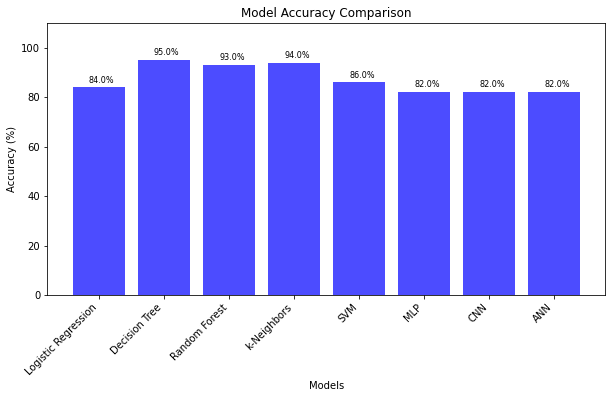

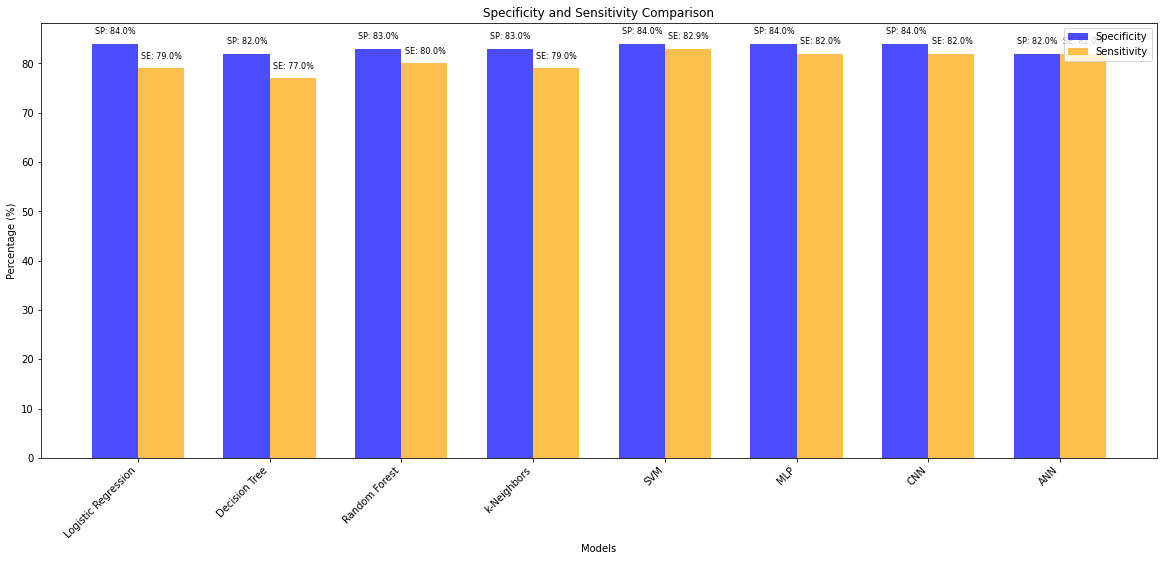

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have accuracy, specificity, and sensitivity values for each model
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'k-Neighbors', 'SVM', 'MLP', 'CNN', 'ANN']
accuracy_values = [84.0, 95.0, 93.0, 94.0, 86.0, 82.0, 82.0, 82.0]
specificity_values = [84.0, 82.0, 83.0, 83.0, 84.0, 84.0, 84.0, 82.0]  
sensitivity_values = [79.0, 77.0, 80.0, 79.0, 82.9, 82.0, 82.0, 82.0]  

# Bar Chart for Accuracy
plt.figure(figsize=(10, 5))
bars = plt.bar(models, accuracy_values, color='blue', alpha=0.7)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 110])  # Adjust the y-axis limit as needed
plt.xticks(rotation=45, ha='right')

# Add annotations for accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracy_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 2, f'{accuracy:.1f}%', fontsize=8)

plt.show()

# Bar Chart for Specificity and Sensitivity Comparison
width = 0.35
ind = np.arange(len(models))

# Filter out None values for specificity and adjust length
filtered_specificity_values = [value if value is not None else 0 for value in specificity_values]
filtered_specificity_values = filtered_specificity_values[:len(models)]

fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.bar(ind - width/2, filtered_specificity_values, width, label='Specificity', color='blue', alpha=0.7)
rects2 = ax.bar(ind + width/2, sensitivity_values, width, label='Sensitivity', color='orange', alpha=0.7)

ax.set_title('Specificity and Sensitivity Comparison')
ax.set_xlabel('Models')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(ind)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add annotations for specificity values on top of the bars
for bar, specificity, sensitivity in zip(rects1, filtered_specificity_values, sensitivity_values):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 2, f'SP: {specificity:.1f}%', fontsize=8, color='black')

# Add annotations for sensitivity values on top of the bars
for bar, sensitivity in zip(rects2, sensitivity_values):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 2, f'SE: {sensitivity:.1f}%', fontsize=8, color='black')

plt.show()


 <h1 style="color:blue">10.Discussion/ Result Analysis </h1>

 <h1 style="color:blue">11.Conclusion </h1>

In this study performed hypothesis testing revealed that the mean radius of benign tumors is less than the mean radius of malignant tumors. The data analysis showed that some features, such as BI-RADS,sensity and Age were more indicative of whether a tumor was malignant or benign. Machine learning algorithms were used to predict the diagnosis of the tumors, If high sensitivity is crucial (minimizing false negatives), Decision Tree, Random Forest, k-Neighbors, SVM, CNN, and ANN are strong contenders as they all achieved bettersensitivity. This report highlights the importance of early detection in the treatment of breast cancer and the use of machine learning algorithms to predict the diagnosis of tumors.